In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [28]:
def hr_far_auc_median(median_category, region, model, season, path_in):
    '''
    Computes the ROC statistics (HR, FAR and AUC normalized by the diagonal (ROC score)) for median-based probabilistic forecasts.

    Parameters:
        median_category (int): The median-based category (1, or 2).
        region (str): The region identifier ('r1', 'r2', 'r3').
        model (str): The forecast model ('cfsv2' or 'seas5').
        season (str): The season identifier. Must be either 'djf' or 'jja' (uppercase).
        path_in (str): The path to the directory containing the input data files.

    Returns:
        dict: A dictionary containing:
            'HR' (numpy.array): Hit rates at different probability thresholds.
            'FAR' (numpy.array): False alarm rates at different probability thresholds.
            'ROC_Score' (float): The area under the ROC curve (AUC) normalized by the diagonal (ROC score).
    '''
    file_name_in = os.path.join(path_in, f'median_prob_and_reference_{season.lower()}_{region}.npz')
    data_in = np.load(file_name_in)

    prob = data_in[model.lower()]
    cat_obs = data_in['merra2']
    prob = prob.reshape((2,prob.shape[1]*prob.shape[2]))
    cat_obs = cat_obs.reshape((cat_obs.shape[0]*cat_obs.shape[1]))

    forecast_probability = prob[median_category - 1,:]

    dichotomous_observed = np.zeros(cat_obs.size)
    dichotomous_observed[cat_obs==median_category] = 1

    # Define Thresholds
    bin_edges = [0.0,0.25, 0.5,0.75,1]
    bin_indices = np.digitize(forecast_probability, bin_edges, right=True)
    
    hit_rates = np.full((len(bin_edges) + 1), np.nan)
    false_alarm_rates = np.full((len(bin_edges) + 1), np.nan)

    hit_rates[0] = 0
    false_alarm_rates[0] = 0


    o_total = sum(dichotomous_observed == 1)
    no_total = sum(dichotomous_observed == 0)


    for bin_idx in range(1, len(bin_edges)+1):
        obs_bin = dichotomous_observed[bin_indices == bin_idx]
        o_bin = sum(obs_bin==1)
        no_bin = sum(obs_bin==0)
        hit_rates[bin_idx] = hit_rates[bin_idx-1] + o_bin/o_total
        false_alarm_rates[bin_idx] = false_alarm_rates[bin_idx-1] + no_bin/no_total

    false_alarm_rates = abs(false_alarm_rates - 1)[::-1]
    hit_rates = abs(hit_rates -1)[::-1]
    auc = np.trapz(hit_rates, false_alarm_rates)
    roc_score = auc - 0.5

    result = {
        'HR': hit_rates,
        'FAR': false_alarm_rates,
        'ROC_Score': roc_score
    }
    
    return result

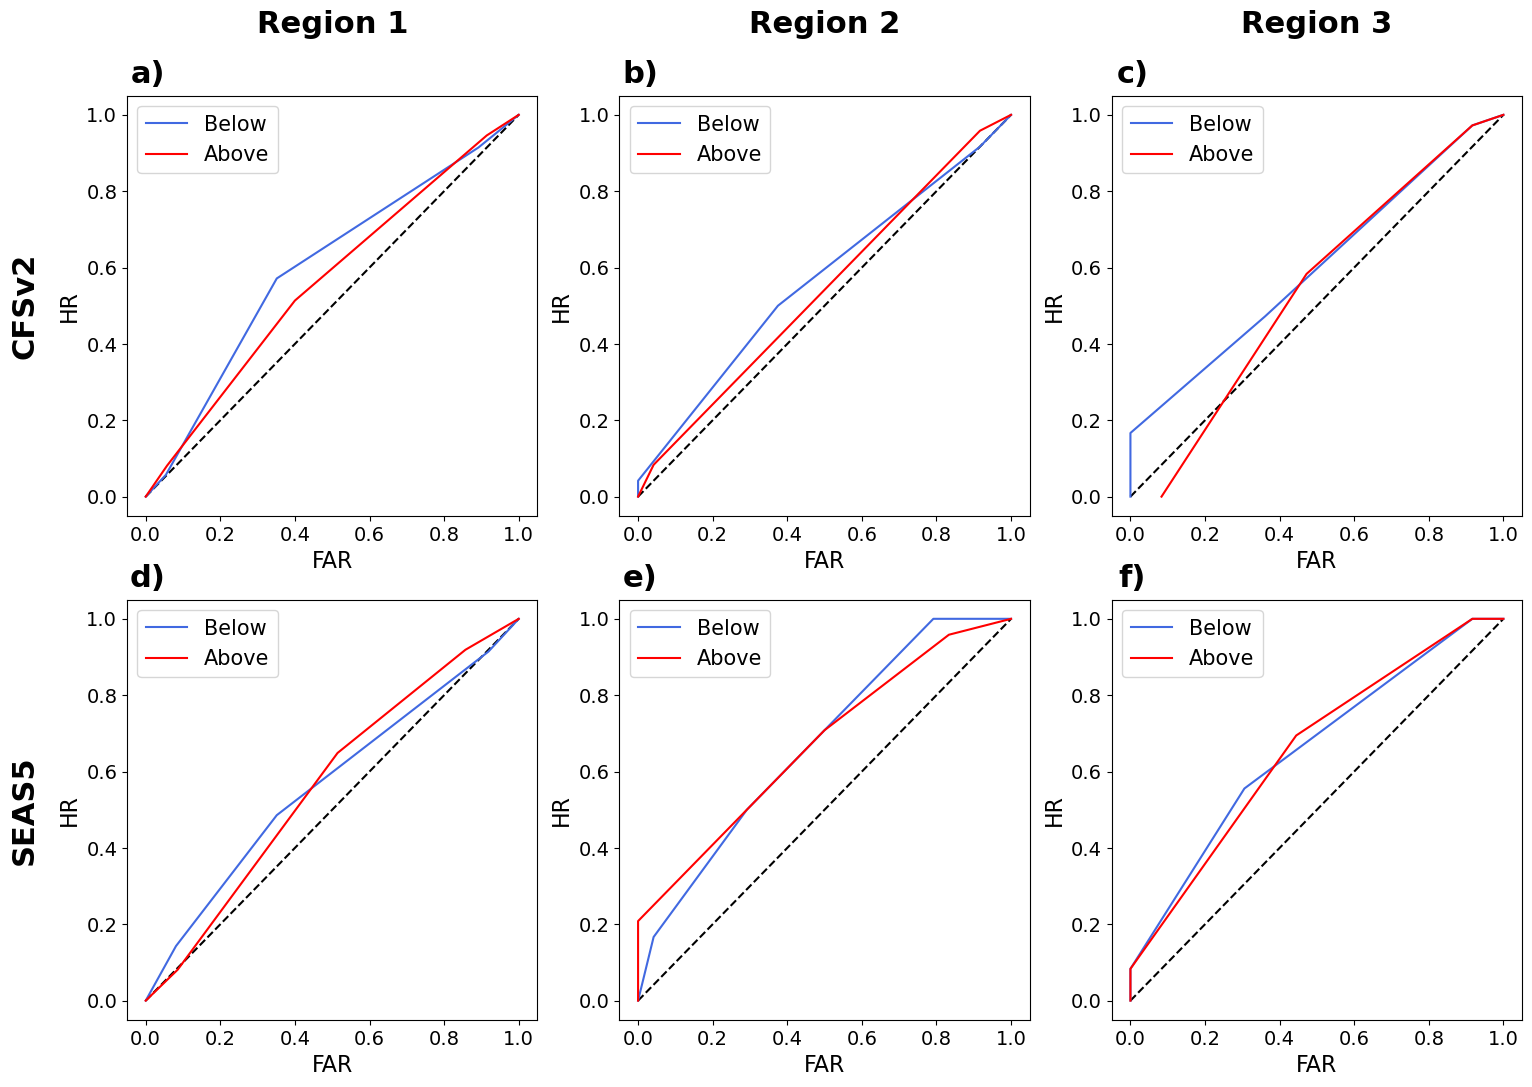

In [22]:
def plot_subplot(ax, season, model, region, path_in):
    median_1 = hr_far_auc_median(1, region, model, season, path_in)
    median_2 = hr_far_auc_median(2, region, model, season, path_in)
    ax.plot([0, 1], [0, 1], linestyle='--', color='black')
    ax.plot(median_1['FAR'], median_1['HR'], 
            linestyle='-', color='royalblue', label='Below')
    ax.plot(median_2['FAR'], median_2['HR'],  
            linestyle='-', color='r', label='Above')
    ax.set_xlabel('FAR', fontsize=16)
    ax.set_ylabel('HR', fontsize=16)
    ax.legend(fontsize=15)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

fig = plt.figure(figsize=(18, 12))
fig.clf()


path_in = '../../../outputs/probabilistic_forecasts/'
season = 'DJF'
models = ['CFSv2', 'SEAS5']
regions = ['r1', 'r2', 'r3']

axes = []
for row, model in enumerate(models):
    for col, region in enumerate(regions):
        ax = plt.subplot2grid((2, 3), (row, col), colspan=1)
        plot_subplot(ax, season, model, region, path_in)
        axes.append(ax)

for i, title in enumerate(['Region 1', 'Region 2', 'Region 3']):
    axes[i].text(0.5, 1.17, title, ha='center', va='center', 
                 fontweight='bold', fontsize=22, transform=axes[i].transAxes)


for i, label in enumerate(['CFSv2', 'SEAS5']):
    axes[i * 3].text(-0.25, 0.5, label, ha='center', va='center', 
                      fontweight='bold', fontsize=22, rotation='vertical', transform=axes[i * 3].transAxes)

tags = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for ax, tag in zip(axes, tags):
    ax.annotate(tag, xy=(0.05, 1.05), xycoords='axes fraction', 
                fontsize=22, fontweight='bold', ha='center', va='center')


plt.show()